# Certification Project III  
## Heart Disease Prediction
### Objective
#### 1. Build the best performing model to predict the probability of heart disease or attack.
#### 2. Identify and list the most important drivers of heart disease or attack.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Load dataset
data_path = "heart_disease_health_indicators_BRFSS2015.csv"
heart_disease_data = pd.read_csv(data_path)

# Display the first few rows and dataset summary to verify the contents
heart_disease_data.info(), heart_disease_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   Diabetes              253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

(None,
    HeartDiseaseorAttack  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
 0                   0.0     1.0       1.0        1.0  40.0     1.0     0.0   
 1                   0.0     0.0       0.0        0.0  25.0     1.0     0.0   
 2                   0.0     1.0       1.0        1.0  28.0     0.0     0.0   
 3                   0.0     1.0       0.0        1.0  27.0     0.0     0.0   
 4                   0.0     1.0       1.0        1.0  24.0     0.0     0.0   
 
    Diabetes  PhysActivity  Fruits  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
 0       0.0           0.0     0.0  ...            1.0          0.0      5.0   
 1       0.0           1.0     0.0  ...            0.0          1.0      3.0   
 2       0.0           0.0     1.0  ...            1.0          1.0      5.0   
 3       0.0           1.0     1.0  ...            1.0          0.0      2.0   
 4       0.0           1.0     1.0  ...            1.0          0.0      2.0   
 
    MentHlth  PhysHlth  DiffWalk  S

### Dataset Overview
#### 1. Structure
* Number of Rows: 253,680
* Number of Columns: 22
* Data Types: All columns are of float64 data type, which suggests that the data has already been preprocessed and encoded.

#### 2. Columns
* Target Variable:
    * HeartDiseaseorAttack: Binary classification (0 = No, 1 = Yes).
* Features:
    * Health-Related Features:
        *HighBP, HighChol, BMI, Smoker, Stroke, Diabetes, PhysActivity, Fruits, Veggies, HvyAlcoholConsump.
    * Healthcare Access and General Health:
        * AnyHealthcare, NoDocbcCost, GenHlth.
    * Mental and Physical Health:
        * MentHlth, PhysHlth, DiffWalk.
    * Demographics:
        *Sex, Age, Education, Income.

#### Nature of Data
* The dataset includes both categorical and continuous features. For example:
    * Categorical Features: Sex, Smoker, Fruits, Veggies.
    * Continuous Features: BMI, MentHlth, PhysHlth.
* Categorical features appear to have been encoded numerically.

#### 4. Missing Values
* No missing values are present in the dataset, as all columns have full counts (253,680 non-null values).

### 5. Preprocessing
* The dataset appears to be cleaned and preprocessed, with all features encoded numerically.
* This structure is suitable for applying machine learning algorithms without additional feature encoding or imputation.


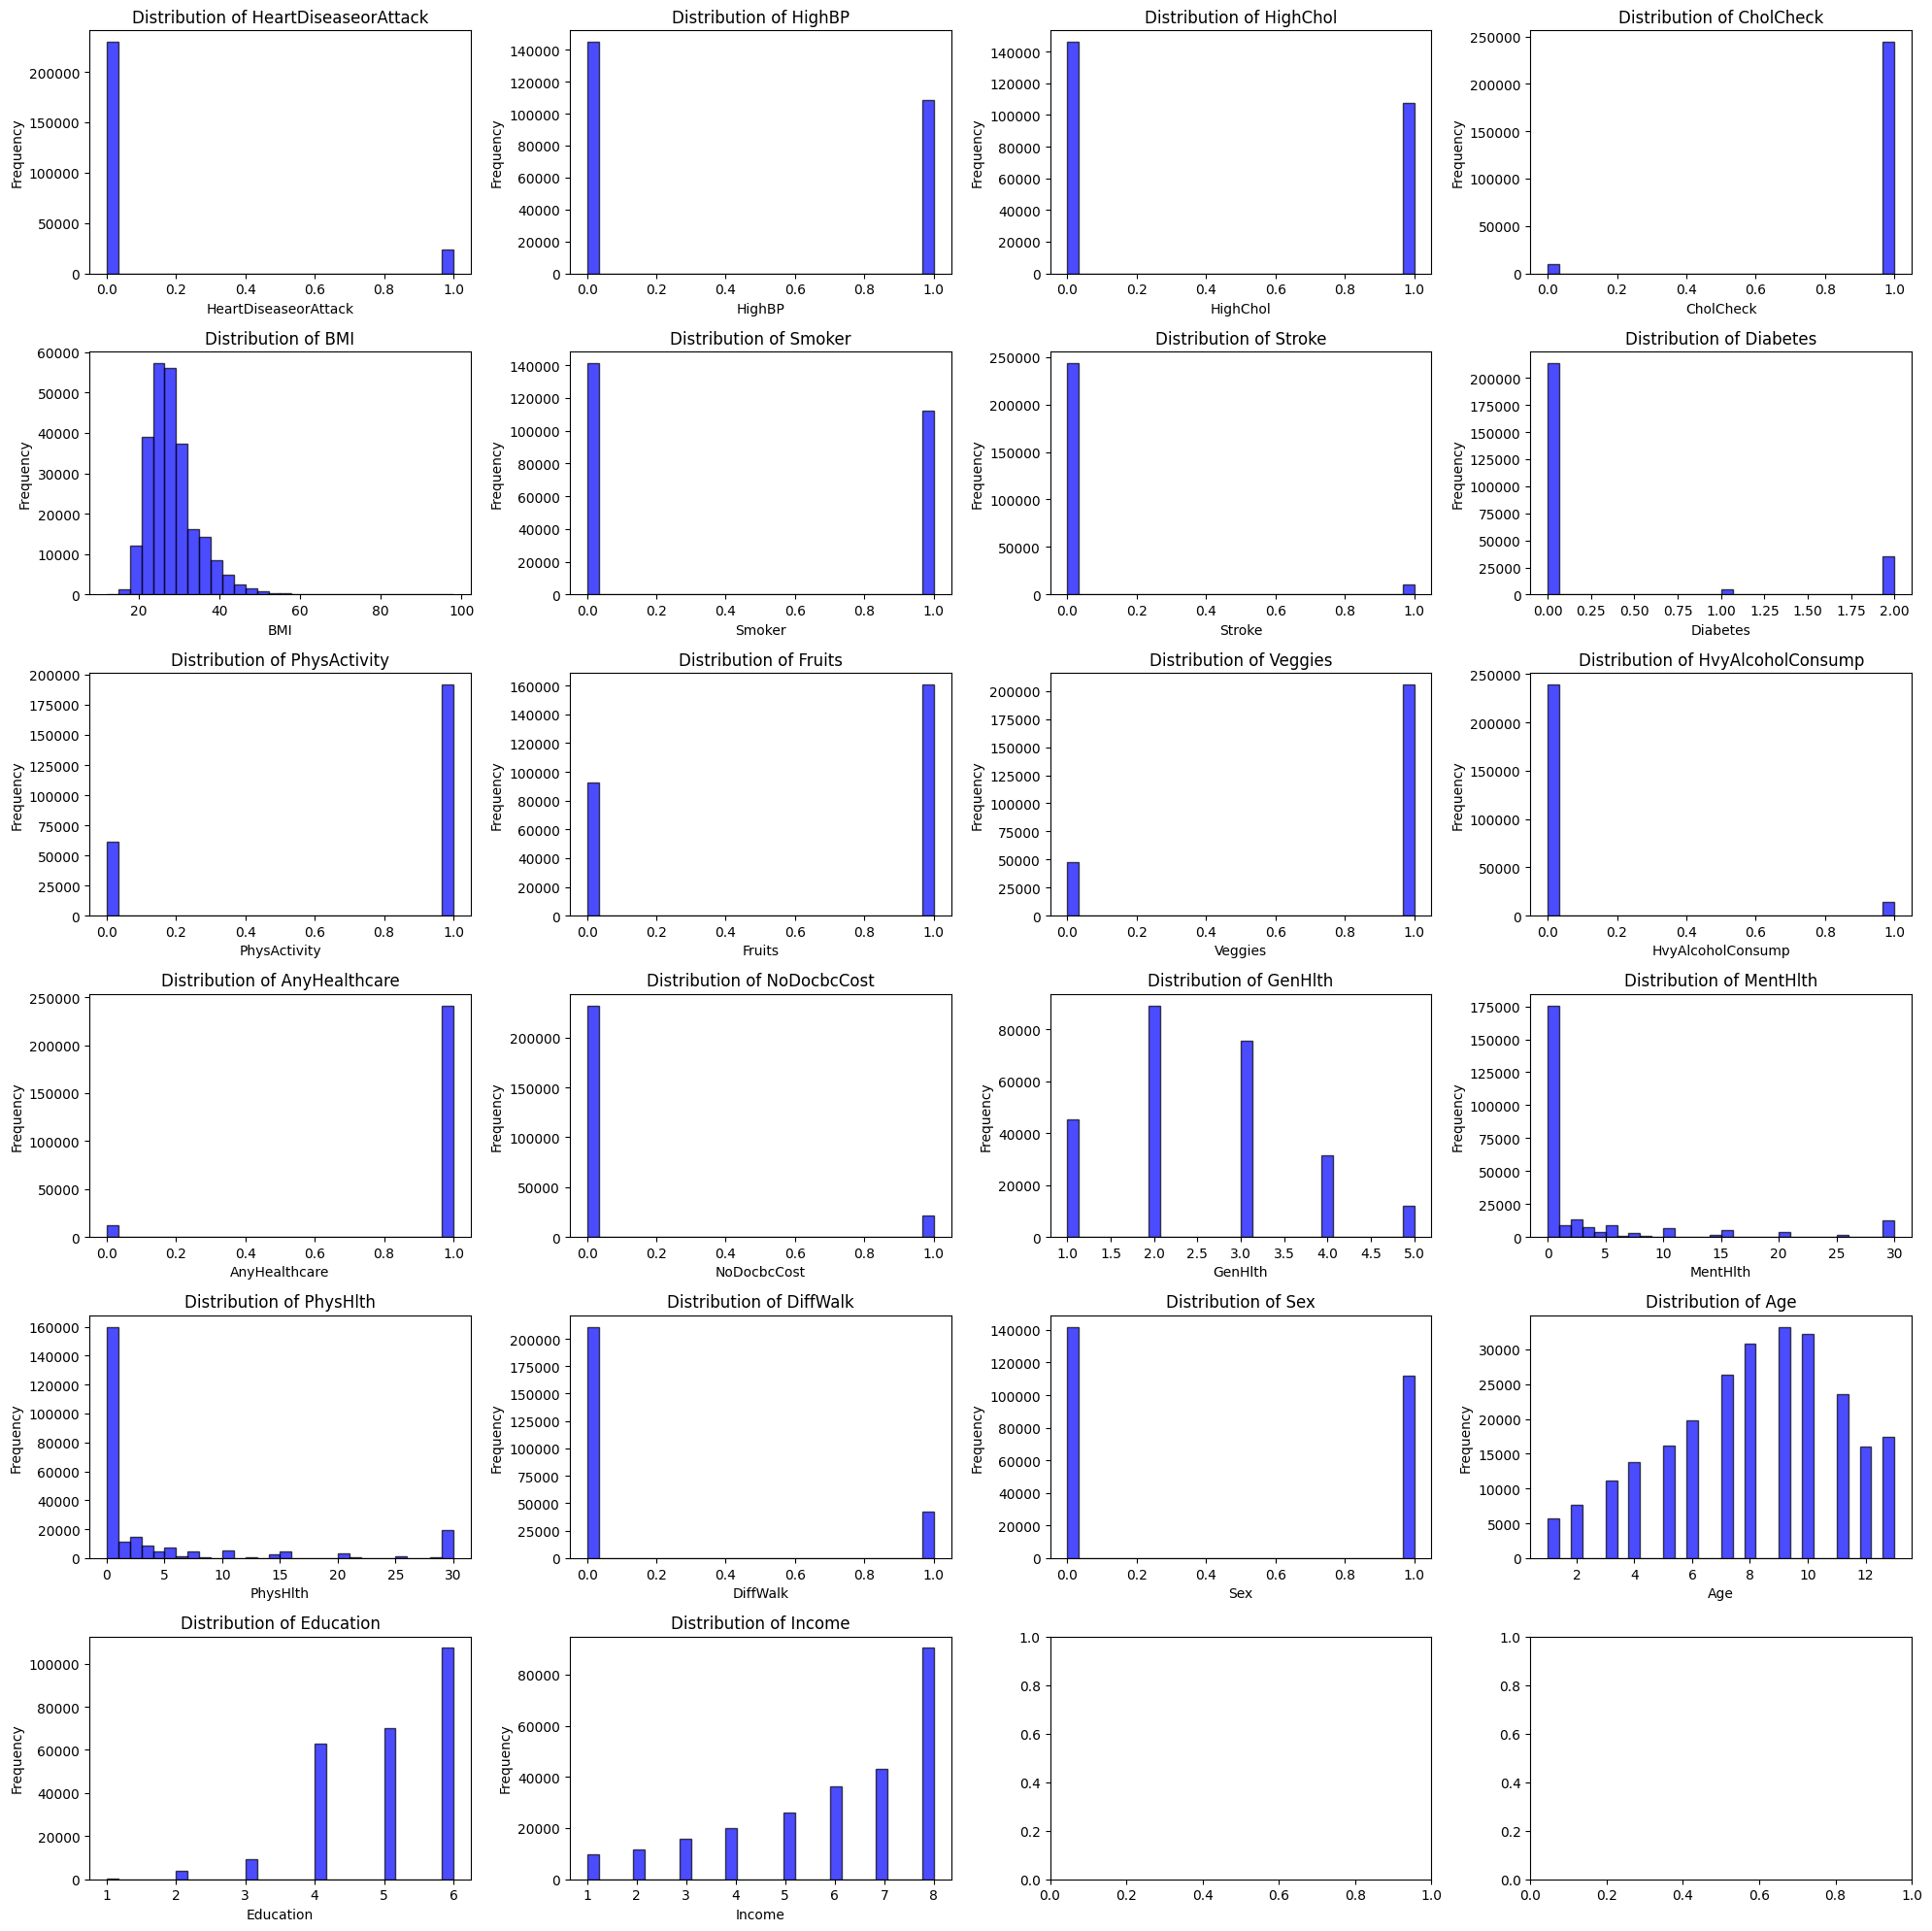

HeartDiseaseorAttack
0.0    90.581441
1.0     9.418559
Name: proportion, dtype: float64

In [2]:
import matplotlib.pyplot as plt
# Plot distributions for numeric features and target variable
fig, axs = plt.subplots(6, 4, figsize=(20, 20))
axs = axs.flatten()
columns = heart_disease_data.columns

for i, col in enumerate(columns):
    axs[i].hist(heart_disease_data[col], bins=30, alpha=0.7, color='blue', edgecolor='black')
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Check the distribution of the target variable
target_distribution = heart_disease_data['HeartDiseaseorAttack'].value_counts(normalize=True) * 100
target_distribution


### Perform Exploratory Data Analysis (EDA):
* Summarize key statistics for continuous variables.
* Analyze the distribution of categorical variables.
* Visualize relationships between features and the target variable.
* Detect and handle any anomalies or outliers.


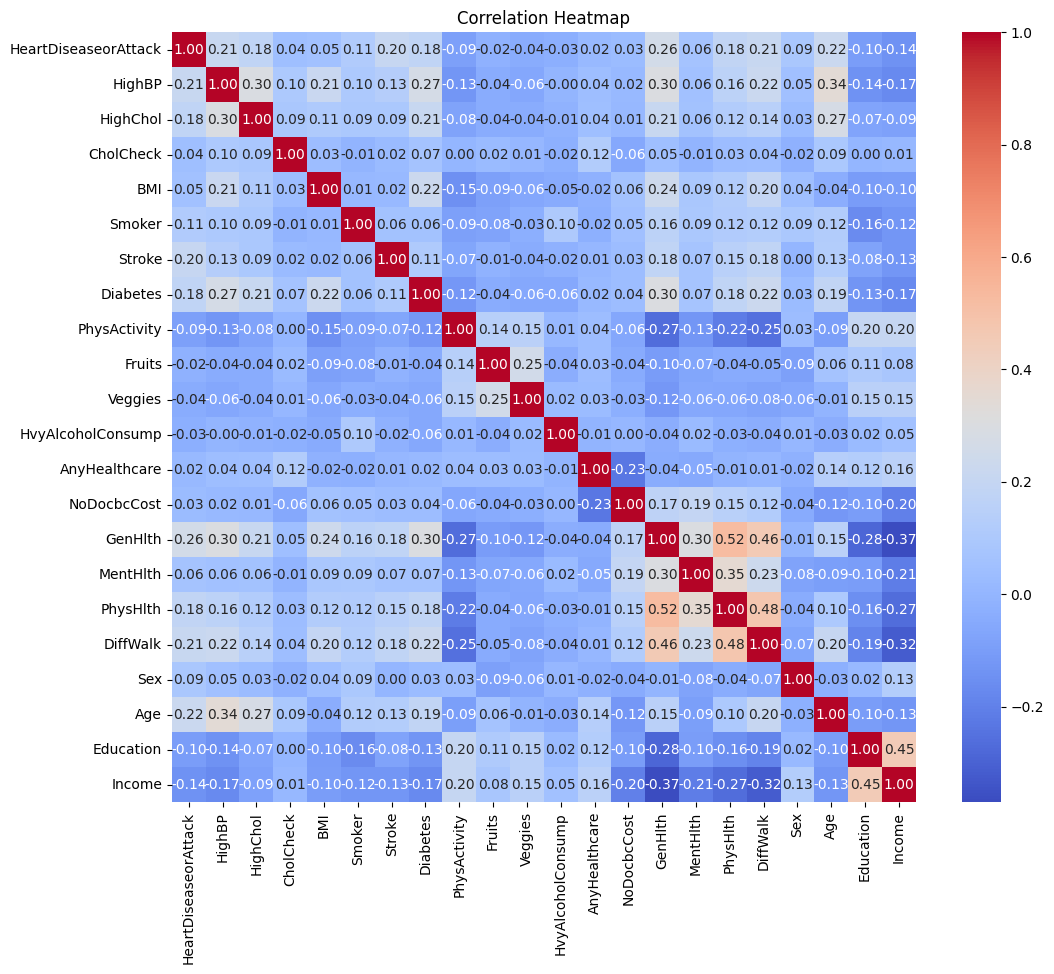

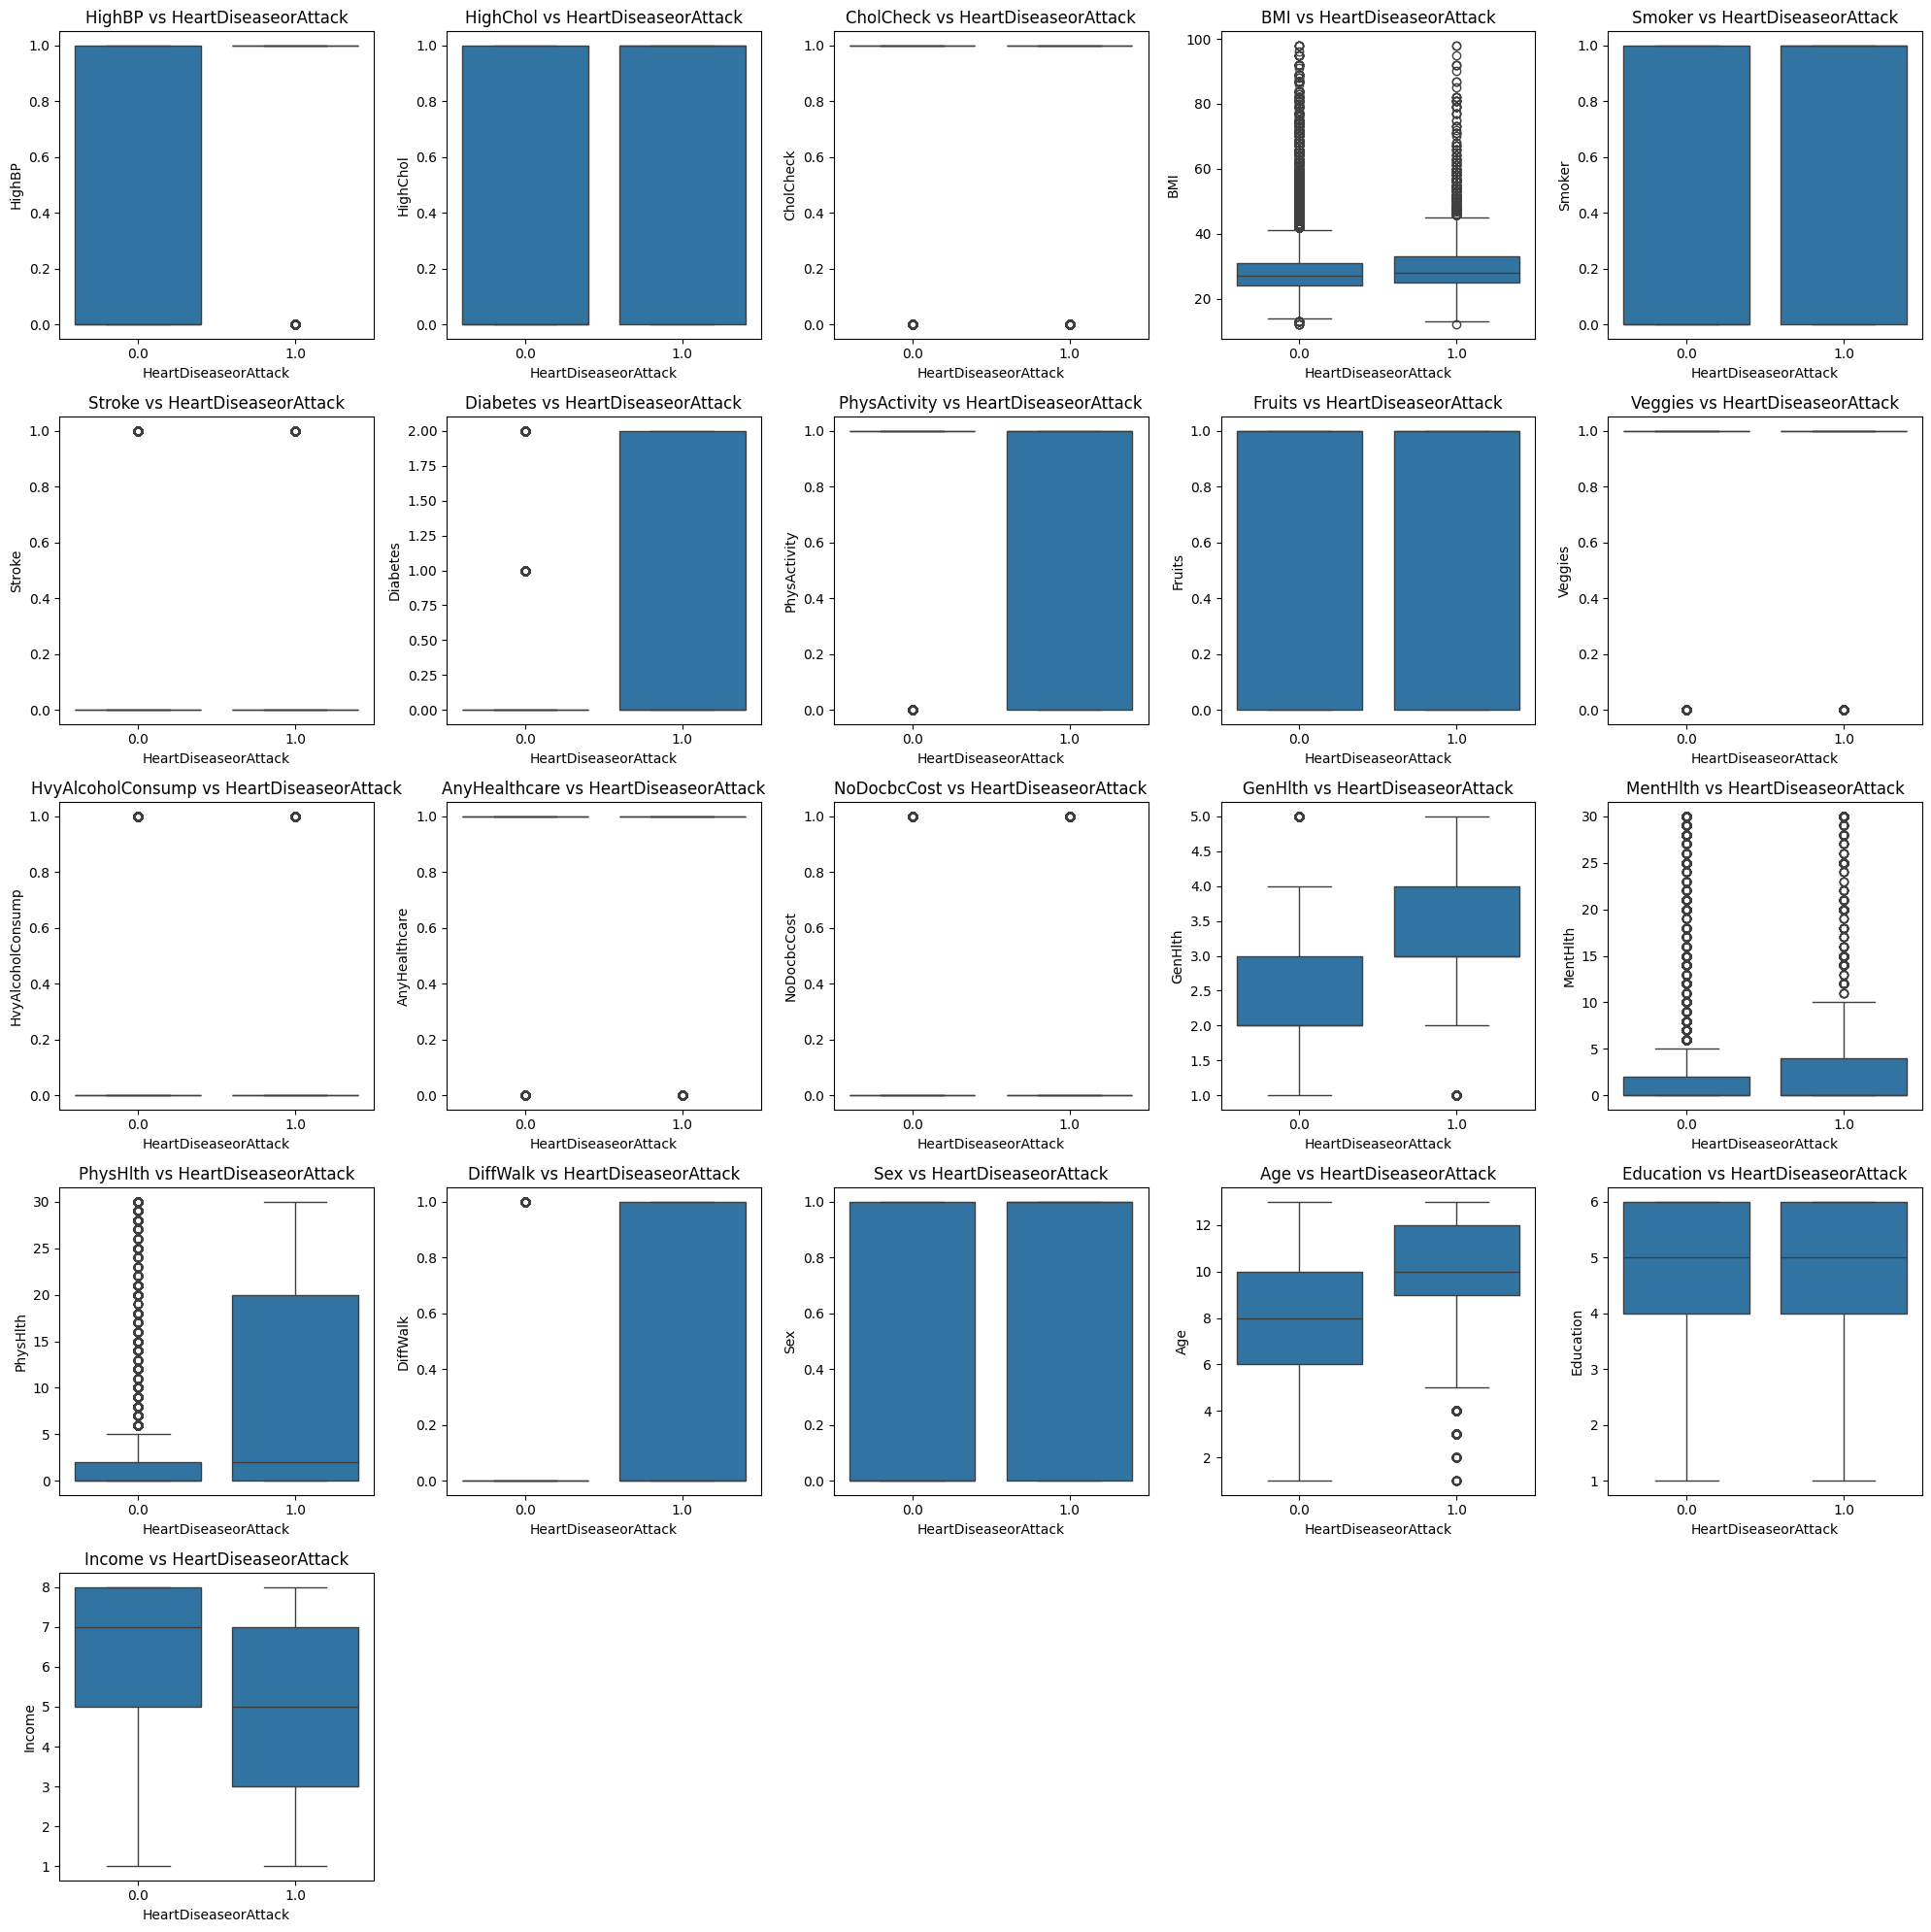

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Compute correlation matrix
correlation_matrix = heart_disease_data.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

# Visualize feature relationships with the target variable
num_features = len(heart_disease_data.columns[1:])  # Exclude target column
num_cols = 5  # Number of columns for subplots
num_rows = math.ceil(num_features / num_cols)  # Dynamically calculate rows

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))
axs = axs.flatten()  # Flatten the 2D array of axes for easy indexing

for i, col in enumerate(heart_disease_data.columns[1:]):  # Exclude target column
    sns.boxplot(
        x=heart_disease_data['HeartDiseaseorAttack'], 
        y=heart_disease_data[col], 
        ax=axs[i]
    )
    axs[i].set_title(f"{col} vs HeartDiseaseorAttack")
    axs[i].set_xlabel("HeartDiseaseorAttack")
    axs[i].set_ylabel(col)

# Remove unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


### Handle imbalanced data
* The number of instances in one class (e.g., no heart disease) greatly outweighs the number in the other class (e.g., heart disease)

### Resampling
* Resampling is a technique used to balance the classes in the training dataset. In this case, it ensures that both the "heart disease" (minority class) and "no heart disease" (majority class) categories have the same number of samples.
* Two options to perform resampling:
    * Oversampling: Duplicates samples from the minority class to match the size of the majority class.
    * SMOTE (Synthetic Minority Oversampling Technique): Generates new synthetic samples for the minority class by interpolating between existing samples.

This code balances the training dataset by either duplicating or synthesizing samples from the minority class, ensuring fair representation of both classes during model training. This improves the model's ability to accurately predict cases of heart disease.

In [4]:

# Preprocessing toggle
USE_RESAMPLING = True  # Set to False to skip resampling
RESAMPLING_METHOD = "oversample"  # Options: "oversample", "smote"

# Separate features and target
X = heart_disease_data.drop('HeartDiseaseorAttack', axis=1)
y = heart_disease_data['HeartDiseaseorAttack']

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

if USE_RESAMPLING:
    if RESAMPLING_METHOD == "oversample":
        # Oversample the minority class
        training_data = pd.concat([X_train, y_train], axis=1)
        minority_class = training_data[training_data['HeartDiseaseorAttack'] == 1]
        majority_class = training_data[training_data['HeartDiseaseorAttack'] == 0]

        minority_oversampled = resample(
            minority_class,
            replace=True,
            n_samples=len(majority_class),
            random_state=42
        )
        balanced_training_data = pd.concat([majority_class, minority_oversampled])
        X_train_balanced = balanced_training_data.drop('HeartDiseaseorAttack', axis=1)
        y_train_balanced = balanced_training_data['HeartDiseaseorAttack']

    elif RESAMPLING_METHOD == "smote":
        smote = SMOTE(random_state=42)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
else:
    X_train_balanced, y_train_balanced = X_train, y_train

# Verify class distribution
print("Class distribution after resampling:")
print(y_train_balanced.value_counts(normalize=True) * 100)



Class distribution after resampling:
HeartDiseaseorAttack
0.0    50.0
1.0    50.0
Name: proportion, dtype: float64


### Model selection
#### Train, evaluate, and compare multiple machine learning models to identify the best-performing one for the classification problem
    1. Model Selection: Identifying the model that performs the best on key metrics such as F1-Score and ROC-AUC.
    2. Evaluation: Understanding how well each model generalizes to unseen data (test set).
    3. Fair Comparison: Using the same dataset and metrics ensures that the models are evaluated consistently.

#### Metrics
* Accuracy: The proportion of correct predictions out of all predictions.
* Precision: Out of all samples predicted as positive, how many were actually positive.
* Recall: Out of all actual positive samples, how many were correctly identified as positive.
* F1-Score: A balanced measure of Precision and Recall (useful when the dataset is imbalanced).
* ROC-AUC: Measures the model's ability to distinguish between classes, independent of the classification threshold.

This code evaluates and compares multiple machine learning models based on their ability to predict heart disease. By analyzing metrics like Precision, Recall, F1-Score, and ROC-AUC, it helps select the best model for further tuning and deployment.

In [14]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=2)
}

# Evaluate models
model_performance = {}

for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    # Calculate metrics
    accuracy = (y_pred == y_test).mean()
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Store performance
    model_performance[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

# Display model performance
performance_df = pd.DataFrame(model_performance).T
print("\nModel Performance Comparison:")
print(performance_df)

Training and evaluating Logistic Regression...
Training and evaluating Random Forest...
Training and evaluating Gradient Boosting...
Training and evaluating K-Nearest Neighbors...

Model Performance Comparison:
                     Accuracy  Precision    Recall  F1-Score   ROC-AUC
Logistic Regression  0.753430   0.248454  0.798912  0.379033  0.847062
Random Forest        0.889408   0.355956  0.215108  0.268162  0.812478
Gradient Boosting    0.739928   0.240951  0.819000  0.372354  0.850261
K-Nearest Neighbors  0.878765   0.250000  0.143545  0.182374  0.589886


### Model Evaluation Summary
#### 1. Logistic Regression:
* Best Performer:
    * Selected as the top model based on F1-Score (0.379), which reflects a reasonable balance between Precision (0.248) and Recall (0.799).
    * High ROC-AUC (0.847) indicates strong ability to distinguish between classes.
* Hyperparameter Tuning:
    * The best configuration was {C: 10, penalty: 'l2', solver: 'liblinear'}.
    * Regularization (C) improved model performance by balancing the trade-off between overfitting and underfitting.

#### 2. Random Forest:
* Strong Accuracy (0.889) but low Recall (0.215) suggests the model struggles to detect positive cases (e.g., cancer).
* While Precision (0.356) is the highest among the models, it comes at the cost of missing many positive cases, as reflected in the F1-Score (0.268).
* Suitable only if Recall is not critical.

#### 3. Gradient Boosting:
* Competitive performance with Logistic Regression, especially in Recall (0.819) and ROC-AUC (0.850).
* Slightly lower F1-Score (0.372) than Logistic Regression, but the model could be considered as an alternative.

#### 4. K-Nearest Neighbors:
* Poor performance compared to the other models, especially in Recall (0.144) and F1-Score (0.182).
* ROC-AUC (0.590) suggests limited capability to distinguish between classes.
* KNN might not be suitable for this dataset due to its high dimensionality and large size, which negatively impact distance-based algorithms.

### Why Logistic Regression is the Top Model
* Logistic Regression achieves the best F1-Score while maintaining a high Recall, which is crucial for tasks like cancer detection.
* Simplicity, computational efficiency, and interpretability make Logistic Regression a practical choice for deployment.


Top 1 Model: ['Logistic Regression']
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best ROC-AUC for Logistic Regression: 0.8474


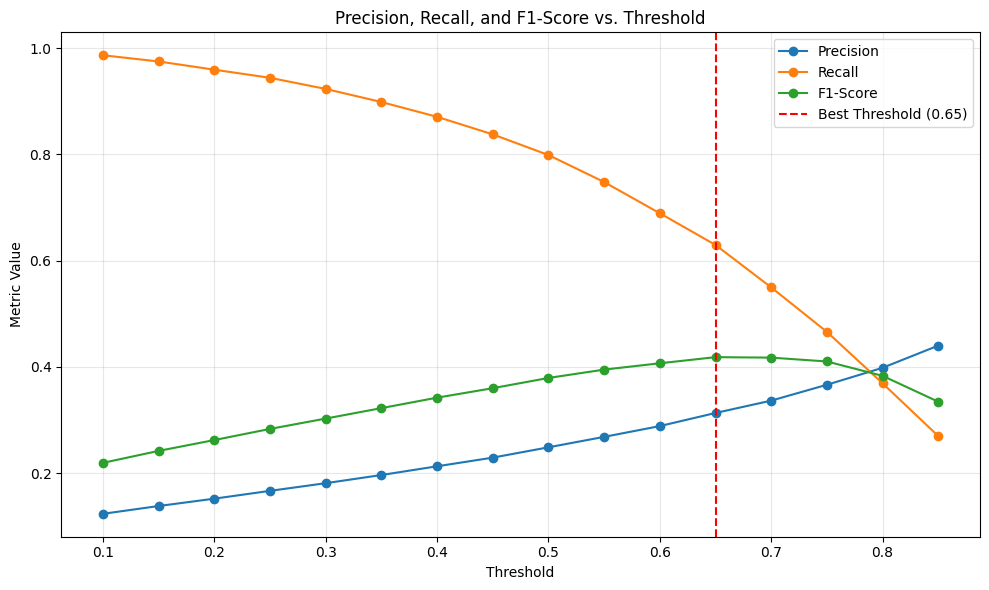

Best threshold for Logistic Regression: 0.6500000000000001


In [15]:

# Select top 1 model
top_models = performance_df.sort_values(by="F1-Score", ascending=False).head(1).index.tolist()
print("\nTop 1 Model:", top_models)

# Hyperparameter tuning for top 2 models
def perform_grid_search(model, param_grid, model_name):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)
    grid_search.fit(X_train_balanced, y_train_balanced)
    print(f"Best parameters for {model_name}:", grid_search.best_params_)
    print(f"Best ROC-AUC for {model_name}: {grid_search.best_score_:.4f}")
    return grid_search.best_estimator_

# Define parameter grids
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}


knn_param_grid = {
    'n_neighbors': [2, 5, 10, 15, 20],
    'weights': ['uniform', 'distance'],  # 'uniform' treats all neighbors equally, 'distance' weighs by proximity
    'metric': ['euclidean', 'manhattan']  # Distance metrics to try
}


# Perform grid search for top models
if 'Logistic Regression' in top_models:
    lr_best_model = perform_grid_search(LogisticRegression(random_state=42, max_iter=1000), lr_param_grid, 'Logistic Regression')

if 'Random Forest' in top_models:
    rf_best_model = perform_grid_search(RandomForestClassifier(random_state=42), rf_param_grid, 'Random Forest')

if 'Gradient Boosting' in top_models:
    gb_best_model = perform_grid_search(GradientBoostingClassifier(random_state=42), gb_param_grid, 'Gradient Boosting')

if 'K-Nearest Neighbors' in top_models:
    knn_best_model = perform_grid_search(KNeighborsClassifier(), knn_param_grid, 'K-Nearest Neighbors')

# Threshold optimization
def optimize_threshold(y_test, y_proba):
    thresholds = np.arange(0.1, 0.9, 0.05)
    precision_scores, recall_scores, f1_scores = [], [], []

    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))

    best_threshold_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_idx]

    # Plot metrics vs. thresholds
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision_scores, label='Precision', marker='o')
    plt.plot(thresholds, recall_scores, label='Recall', marker='o')
    plt.plot(thresholds, f1_scores, label='F1-Score', marker='o')
    plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold ({best_threshold:.2f})')
    plt.title('Precision, Recall, and F1-Score vs. Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return best_threshold

# Example threshold optimization for one model
if 'Logistic Regression' in top_models:
    y_proba_lr = lr_best_model.predict_proba(X_test)[:, 1]
    lr_best_threshold = optimize_threshold(y_test, y_proba_lr)
    print(f"Best threshold for Logistic Regression: {lr_best_threshold}")

if 'Random Forest' in top_models:
    y_proba_rf = rf_best_model.predict_proba(X_test)[:, 1]
    rf_best_threshold = optimize_threshold(y_test, y_proba_rf)
    print(f"Best threshold for Random Forest: {rf_best_threshold}")

if 'Gradient Boosting' in top_models:
    y_proba_gb = gb_best_model.predict_proba(X_test)[:, 1]
    gb_best_threshold = optimize_threshold(y_test, y_proba_gb)
    print(f"Best threshold for Gradient Boosting: {gb_best_threshold}")

if 'K-Nearest Neighbors' in top_models:
    # For KNN, probabilities are available through predict_proba
    y_proba_knn = knn_best_model.predict_proba(X_test)[:, 1]
    knn_best_threshold = optimize_threshold(y_test, y_proba_knn)
    print(f"Best threshold for K-Nearest Neighbors: {knn_best_threshold}")


#### 1. Hyperparameter Tuning
* Objective: To find the optimal set of hyperparameters for the top models to improve their performance.
* Logistic Regression Results:
    * Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
        * C=10: Indicates moderate regularization strength, allowing the model to generalize without overfitting.
        * penalty='l2': Ridge regularization was most effective in this scenario.
        * solver='liblinear': A solver optimized for small-to-medium-sized datasets worked best.
* Best ROC-AUC: 0.8474, indicating good overall classification performance.

#### 2. Threshold Optimization
* Why It Was Done:
    * The default threshold (0.5) might not achieve the best balance between Precision and Recall, so optimization helps to identify the threshold that maximizes F1-Score.
* Best Threshold Identified: 0.65
    * This threshold strikes a better balance for the classification task, likely improving Precision while maintaining Recall at a reasonable level.

#### 3. Overall Impact of the Workflow
* Improved Logistic Regression Performance:
    * The combination of hyperparameter tuning and threshold optimization ensures the model is both well-calibrated and effective at detecting positive cases (e.g., cancer).

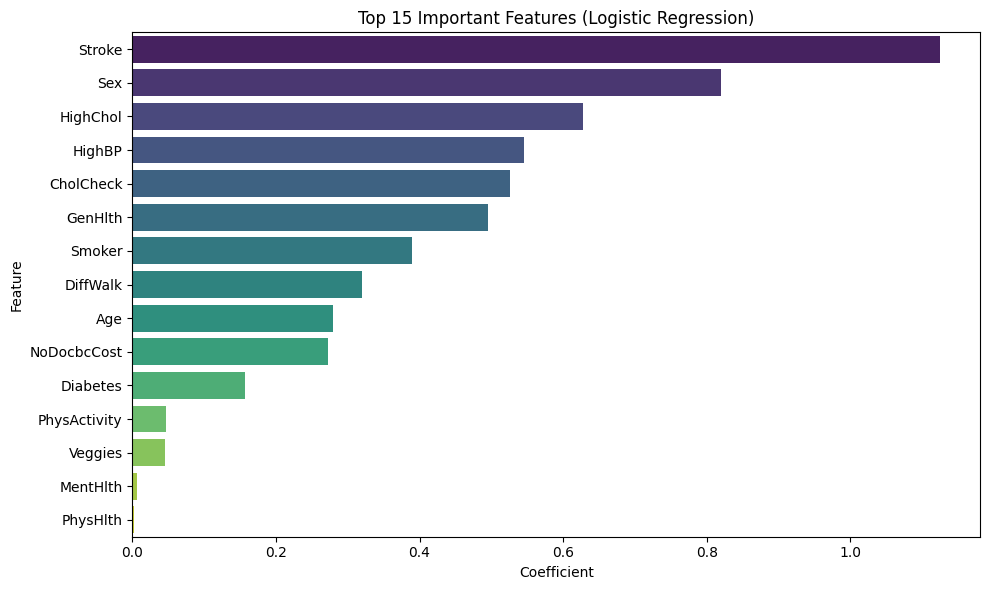

Most important drivers for a heart disease or attack: 
          Feature  Coefficient
5         Stroke     1.124467
17           Sex     0.819783
1       HighChol     0.628087
0         HighBP     0.544806
2      CholCheck     0.525364
13       GenHlth     0.494810
4         Smoker     0.390141
16      DiffWalk     0.320229
18           Age     0.279326
12   NoDocbcCost     0.272372
6       Diabetes     0.156294
7   PhysActivity     0.047056
9        Veggies     0.045915
14      MentHlth     0.005712
15      PhysHlth     0.002758


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix

# Use the best Logistic Regression model
best_lr_model = LogisticRegression(C=10, penalty='l2', solver='liblinear', random_state=42)
best_lr_model.fit(X_train_balanced, y_train_balanced)

# Feature Importance (Top 15 Features)
coefficients = best_lr_model.coef_[0]
features = X_train.columns
feature_importance = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
top_15_features = feature_importance.sort_values(by='Coefficient', ascending=False).head(15)

# Plot Top 15 Features
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=top_15_features, palette='viridis')
plt.title('Top 15 Important Features (Logistic Regression)')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("Most important drivers for a heart disease or attack: \n", top_15_features)


### Feature Importance Analysis
#### Objective
The purpose of this analysis is to identify the most important factors contributing to the prediction of heart disease or attack based on the coefficients of the Logistic Regression model. Features with higher absolute coefficients have a stronger impact on the model's predictions.

#### 1. Top Drivers of Heart Disease or Attack:

* The top features with the highest positive coefficients (strongest predictors) include:
    * Stroke: Patients with a history of stroke are highly likely to develop heart disease.
    * Sex: Gender significantly contributes to the likelihood of heart disease (male patients are typically at higher risk).
    * HighChol: High cholesterol is a well-established risk factor for heart disease.
    * HighBP: High blood pressure contributes strongly to the likelihood of heart disease.
    * CholCheck: Patients who have had cholesterol checks are slightly more likely to be diagnosed, possibly because testing is more common among at-risk individuals.
    * GenHlth: Self-reported general health has a noticeable impact on predictions, with poor general health correlating with heart disease.

#### 2. Behavioral and Lifestyle Factors:
* Smoker: Smoking remains a critical risk factor for heart disease, as indicated by the positive coefficient.
* PhysActivity: Physical activity appears to have a slight protective effect, though its coefficient is smaller compared to other factors.
* Veggies: Consuming vegetables daily has a minor positive impact on reducing risk.

#### 3. Functional Impairments:
* DiffWalk: Difficulty walking or climbing stairs is an important factor, often associated with reduced physical activity or other comorbidities.

#### 4. Demographics:
* Age: Older age is a significant risk factor for heart disease.
* NoDocbcCost: Patients unable to see a doctor due to cost barriers are at a slightly increased risk, reflecting disparities in access to healthcare.

#### 5. Health-Related Factors:
* Diabetes: As expected, diabetes is a contributing factor to heart disease, though its coefficient is less prominent than Stroke, HighBP, or HighChol.


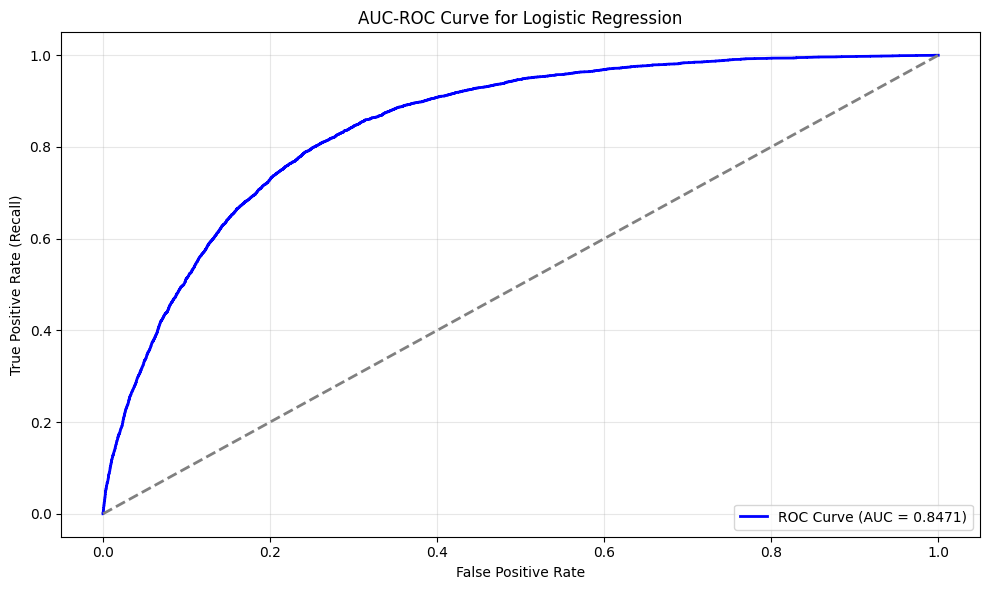

AUC = 0.8471


In [16]:
# AUC-ROC Curve
y_test_proba = best_lr_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('AUC-ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f'AUC = {roc_auc:.4f}' )


### Area Under Curve (AUC)
The Area Under the ROC Curve (AUC) summarizes the ROC curve into a single number, measuring the ability of the model to distinguish between the positive and negative classes.
* AUC Ranges:
    * 1.0: Perfect model.
    * 0.9–1.0: Excellent model.
    * 0.8–0.9: Good model.
    * 0.7–0.8: Fair model.
    * 0.5–0.7: Poor model.
    * 0.5: No better than random guessing.

### Why Use the ROC and AUC?
* Compare Models: ROC curves and AUC scores are great for comparing classification models.
* Imbalanced Data: They help evaluate models when class distribution is imbalanced, as metrics like accuracy can be misleading.
* Threshold Decisions: If you care about optimizing thresholds for TPR and FPR (e.g., in fraud detection or medical diagnosis).


Evaluation Metrics:
Accuracy: 0.7536
Precision: 0.2486
Recall: 0.7989
F1-Score: 0.3792


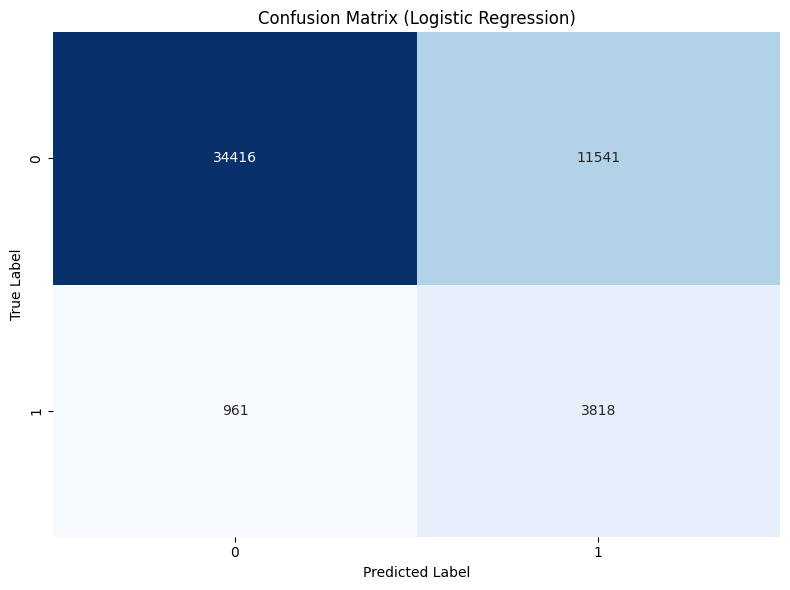

In [9]:
# Predictions and Metrics
y_test_pred = best_lr_model.predict(X_test)

# Evaluation Metrics
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
accuracy = best_lr_model.score(X_test, y_test)

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Logistic Regression)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

### Key Observations from the Results
#### 1. High Recall (0.7989):
* What It Means: The model identifies ~80% of actual cancer cases correctly.
* Why It’s Important: In cancer detection, Recall is critical because missing a cancer diagnosis (False Negative) can delay treatment and lead to worse outcomes. This high Recall suggests the model does well at minimizing False Negatives.

#### 2. Low Precision (0.2486):
* What It Means: Of all the cases the model predicts as positive (cancer), only ~25% are correct.
* Why It’s a Concern: A low Precision means a high number of False Positives, where the model flags someone as having cancer when they don’t. This can lead to:
    * Emotional stress for patients.
    * Unnecessary follow-up tests (which can be invasive, expensive, and time-consuming).

#### 3. F1-Score (0.3792):
* The F1-Score reflects the trade-off between Precision and Recall. In this case, the score is relatively low, driven by the imbalance between high Recall and low Precision.

#### 4. Accuracy (0.7536):
* Accuracy is not as relevant in cancer detection because class imbalances often make it misleading. For instance, if only 10% of patients have cancer, a model predicting "no cancer" for everyone would achieve 90% accuracy but be completely useless.


### Conclusion
* The model's AUC-ROC (0.8471) and Recall (0.7989) are strong indicators that it performs well in identifying cancer cases.
* The focus should now shift toward improving Precision to reduce False Positives while maintaining high Recall, ensuring the model is practical and efficient for deployment in healthcare settings.